In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

sys.path.append(r"../")
from data_loader import load_data, get_entire_data, get_features, split_train_valid_test_categorical
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.cluster import KMeans

from catboost import CatBoostRegressor

from datetime import datetime
import numpy as np

In [19]:
IS_CUSTOM = True
USE_VALID = True
DROPS = [
        "assessmentItemID", "testId", "Timestamp",'year', 'day', 'minute', 'second', 
        # 'userID',
        # 'KnowledgeTag',
        # 'userAnswerRate',
        # 'userSolvedLen',
        # 'testAnswerRate',
        # 'testSolvedLen', 
        # 'tagAnswerRate', 
        # 'tagSolvedLen',
        # 'itemAnswerRate', 
        # 'itemSolvedLen', 
        # 'month', 
        # 'hour',
        # 'first3', 
        # 'mid3', 
        # 'last3', 
        # 'timeConcentrationRate',
        # 'timeConcentrationCount', 
        # 'timeConcentrationLevel',
        # 'user_correct_answer', 
        # 'user_total_answer', 
        # 'user_acc',
        # 'monthAnswerRate', 
        # 'monthSolvedCount'
    ]

In [20]:
# def clustering(
#     items,
#     n_clusters=27, 
#     init='k-means++', 
#     max_iter=300, 
#     random_state=42
# ):
#     """ Clustering data """
#     kmeans = KMeans()
#     kmeans.fit(items)
#     return kmeans.labels_

# def get_clu_tag_item(df):
#     """clustering tag and item"""
#     new_df = df.copy()
#     new_df["clu_tag_item"]=clustering(new_df[["KnowledgeTag","first3","testAnswerRate"]])
#     print(new_df["clu_tag_item"])
#     return new_df
    
_train, _test = load_data(IS_CUSTOM=IS_CUSTOM)
entire_data = get_entire_data(_train, _test)
df = get_features(entire_data).drop(DROPS, axis=1)
train, valid, test = split_train_valid_test_categorical(df)
if not USE_VALID:
    train = pd.concat([train,valid])
    valid = valid.drop([val for val in valid.index], axis=0)

In [21]:
x_train = train.drop(["answerCode"], axis=1)
y_train = train["answerCode"]
x_valid = valid.drop(["answerCode"], axis=1)
y_valid = valid["answerCode"]

# CTB preprocessing

In [53]:
def ctb_preprocessing(data):
    for col in data.columns:
        data[col] = data[col].astype(str).fillna("-1")
    return data


x_train = ctb_preprocessing(x_train)
x_valid = ctb_preprocessing(x_valid)
test = ctb_preprocessing(test)
cat_features = x_train.columns[x_train.nunique()<200].to_list()
cat_features


['itemSolvedLen',
 'month',
 'hour',
 'first3',
 'mid3',
 'last3',
 'timeConcentrationRate',
 'timeConcentrationCount',
 'timeConcentrationLevel',
 'monthAnswerRate',
 'monthSolvedCount']

# CatBoostRegressor

In [56]:
model = CatBoostRegressor(cat_features=cat_features, task_type="GPU", leaf_estimation_iterations=10, od_type="Iter", logging_level="Silent")

if USE_VALID:
    model = CatBoostRegressor(cat_features=cat_features, task_type="GPU", use_best_model=True, leaf_estimation_iterations=10, od_type="Iter", logging_level="Silent", early_stopping_rounds=100)

n_splits=5
f1 = []
predict = None
param_grid = {
        'iterations': [500],
        'depth': [5],
        'learning_rate': [0.01],
        # 'custom_loss': ['TotalF1'],
        # 'eval_metric': ['TotalF1'],
        # 'random_seed': [1234],
        # 'min_data_in_leaf': [4],
        # 'max_leaves': [200],
        # 'l2_leaf_reg': [100],
        # 'border_count': [100],
        # 'bagging_temperature': [500],
}
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv = KFold(n_splits=6, random_state=42, shuffle=True)

gcv = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
    pre_dispatch=8,
    verbose=1,
)

In [57]:
if USE_VALID:
    gcv.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=True)
else:
    gcv.fit(x_train, y_train, verbose=True)

print("final params", gcv.best_params_)
print("best score", gcv.best_score_)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
final params {'depth': 5, 'iterations': 500, 'learning_rate': 0.01}
best score 0.7962253660251521


In [58]:
# SAVE OUTPUT
model = gcv.best_estimator_
sub = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
sub["prediction"] = model.predict(test.drop("answerCode", axis=1))

output_dir = "./output/"
now = datetime.now()
now_str = "{:%Y-%m-%d_%H:%M:%S}".format(now)
file_name = f"CTB_R_grid_kfold_custom_submission_{now_str}.csv"
write_path = os.path.join(output_dir, file_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(sub["prediction"]):
        w.write("{},{}\n".format(id, p))

writing prediction : ./output/XGB_grid_kfold_custom_submission_339290.csv


In [59]:
def get_accuracy(PRED_PATH=file_name):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"

In [60]:
if IS_CUSTOM:
    print(get_accuracy("output/" + file_name))


accuracy_score: 0.7029569892473119
roc  auc_score: 0.7742331916636795


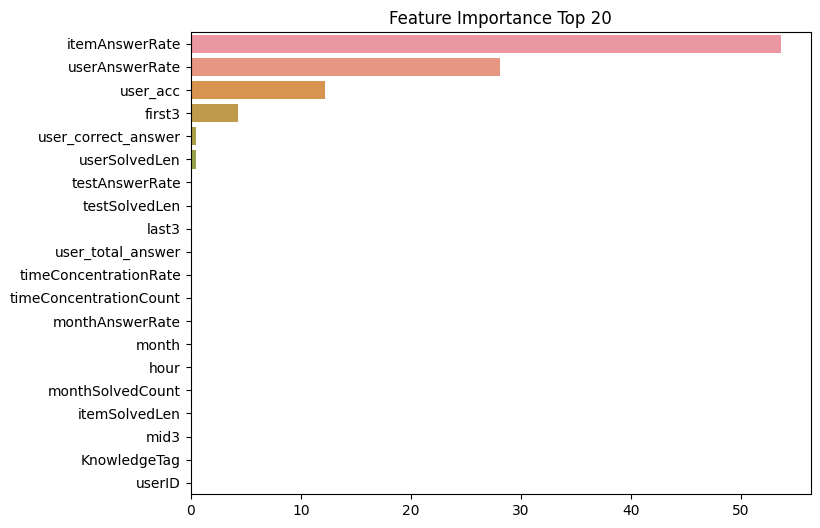

In [63]:
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [64]:
file_name

'XGB_grid_kfold_custom_submission_339290.csv'